In [1]:
%matplotlib inline
import numpy as np
from copy import copy
import copy
import math, random
import matplotlib.pyplot as plt                   
from matplotlib.patches import Ellipse 
import scipy
from scipy.stats import norm

In [2]:
actual_x = np.array([0.0,0.0,0.0])#ロボットの位置
u = np.array([0.2,math.pi / 180.0 * 20])#ロボットの行動の指令
actual_landmarks = [np.array([-0.5,0.0]),np.array([0.5,0.0]),np.array([0.0,0.5])]#landmark設定

In [3]:
class Particle:#particleの宣言
    def __init__(self,p,w):
        self.pose = p
        self.weight = w
    
    def __repr__(self):
        return "pose: " + str(self.pose) + " weight: " + str(self.weight)
particles = [Particle(actual_x,1.0/100.0) for i in range(100)]#重み0.01で100個生成

In [4]:
def sampling(particles):#リサンプリング
    accum = []
    sm = 0.0

    for p in particles:
        accum.append(p.weight + sm)
        sm += p.weight
    
    pointer = random.uniform(0.0,1.0/len(particles))
    
    new_particles = []
    particles_num = len(particles)
    while pointer < 1.0:
        if accum[0] >= pointer:
            new_particles.append(
                Particle(copy.deepcopy(particles[0].pose),1.0/particles_num)
            )
            pointer += 1.0/particles_num
        else:
            accum.pop(0)
            particles.pop(0)
    return new_particles

In [5]:
def f(x_old,u):#ロボットの位置計算
    pos_x, pos_y, pos_theta = x_old
    act_fw, act_rot = u
    
    act_fw = random.gauss(act_fw,act_fw/10)
    dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0)
    act_rot = random.gauss(act_rot,act_rot/10)
    
    pos_x += act_fw * math.cos(pos_theta + dir_error)
    pos_y += act_fw * math.sin(pos_theta + dir_error)
    pos_theta += act_rot
    
    return np.array([pos_x,pos_y,pos_theta])

In [6]:
def relative_landmark_pos(pose,landmark):#landmarkとの関係計算
    x,y,theta = pose
    lx,ly = landmark
    distance = math.sqrt((x -lx)**2 + (y-ly)**2)
    direction = math.atan2(ly-y, lx-x) - theta
    
    return (distance, direction,lx,ly)

In [7]:
def observation(pose, landmark):#観測用関数
    actual_distance,actual_direction,lx,ly = relative_landmark_pos(pose,landmark)
    
    if (math.cos(actual_direction) < 0.0):
        return None
    
    measured_distance = random.gauss(actual_distance,actual_distance*0.1)  
    measured_direction = random.gauss(actual_direction,5.0/180.0*math.pi)  
    
    return (measured_distance, measured_direction,lx,ly)

In [8]:
def observations(pose,landmarks):
    ms = []
    for ln in landmarks:
        m = observation(pose,ln)
        if m != None:
            ms.append(m)
    return ms
    #return filter(lambda x: x != None, [ observation(pose,e) for e in landmarks])

In [9]:
def draw_landmarks(landmarks):
    xs = [ e[0] for e in landmarks]
    ys = [ e[1] for e in landmarks]
    plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")

In [10]:
def draw_observation(pose,  measurement):
    x,y,theta = pose
    distance, direction,lx,ly = measurement
    lx = distance*math.cos(theta + direction) + x
    ly = distance*math.sin(theta + direction) + y
    plt.plot([pose[0],  lx],[pose[1],  ly],color="pink",label="observe")

In [11]:
def draw_observations(pose,  measurements):
    for m in measurements:
        draw_observation(pose, m)

In [12]:
def draw(pose,particles):    
    fig = plt.figure(i,figsize=(8, 8))
    sp = fig.add_subplot(111, aspect='equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)
    
    xs = [e.pose[0] for e in particles]
    ys = [e.pose[1] for e in particles]
    vxs = [math.cos(e.pose[2])*e.weight for e in particles]  
    vys = [math.sin(e.pose[2])*e.weight for e in particles]  
    plt.quiver(xs,ys,vxs,vys,color="blue",label="particles")
    
    plt.quiver([pose[0]],[pose[1]],[math.cos(pose[2])],[math.sin(pose[2])],color="red",label="actual robot motion")

In [13]:
def likelihood(pose, measurement):
    x,y,theta = pose
    distance, direction,lx,ly = measurement
    
    rel_distance, rel_direction, tmp_x,tmp_y = relative_landmark_pos(pose,(lx,ly))

    return norm.pdf(x = distance - rel_distance, loc = 0.0, scale = rel_distance / 10.0)  \
             * norm.pdf(x = direction - rel_direction, loc = 0.0, scale = 5.0/180.0 * math.pi)

In [14]:
def change_weights(particles, measurement):
    for p in particles:
        p.weight *= likelihood(p.pose, measurement)
        
    ws = [ p.weight for p in particles ]
    s = sum(ws)
    for p in particles: p.weight = p.weight / s

In [15]:
path = [actual_x]
particle_path = [copy.deepcopy(particles)]
measurementss = [observations(actual_x, actual_landmarks)]

In [16]:
for i in range(10):
    actual_x = f(actual_x,u)
    path.append(actual_x)
    ms = observations(actual_x,actual_landmarks)
    measurementss.append(ms)
    for p in particles:
        p.pose = f(p.pose,u)
    for m in ms:
        change_weights(particles, m)
    particles = sampling(particles)
    particle_path.append(copy.deepcopy(particles))

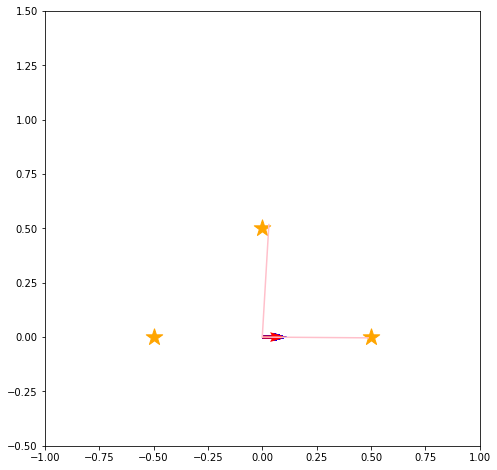

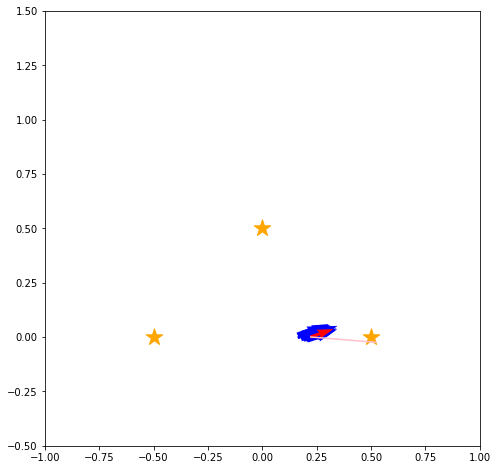

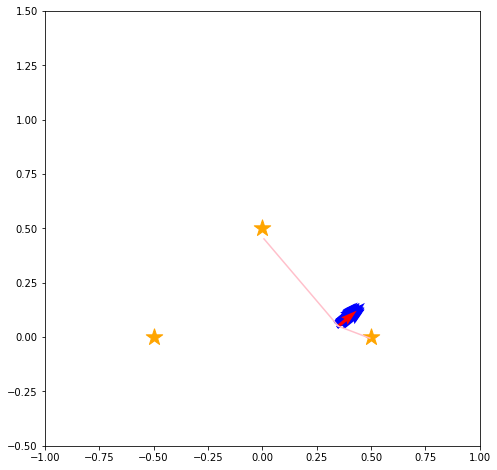

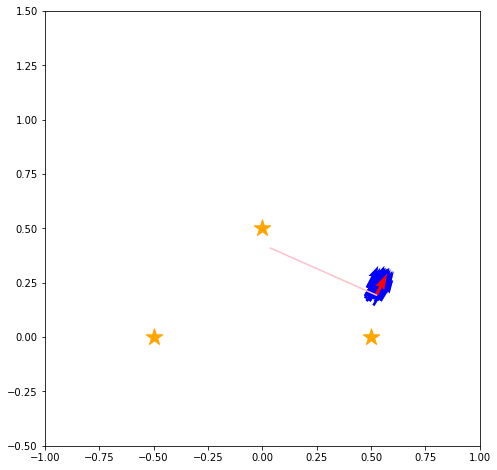

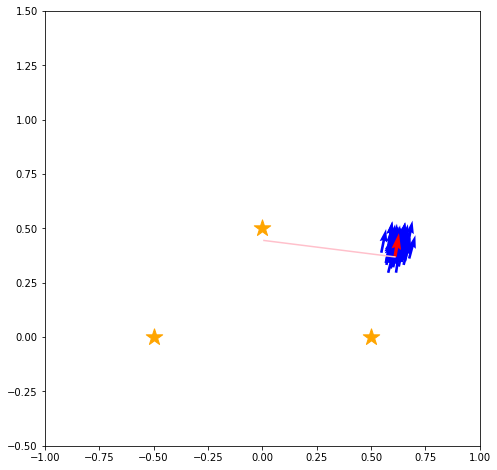

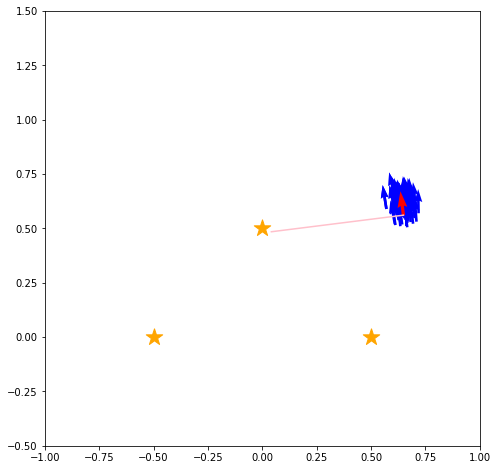

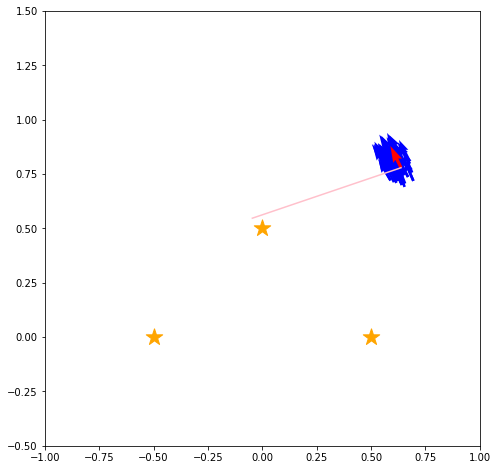

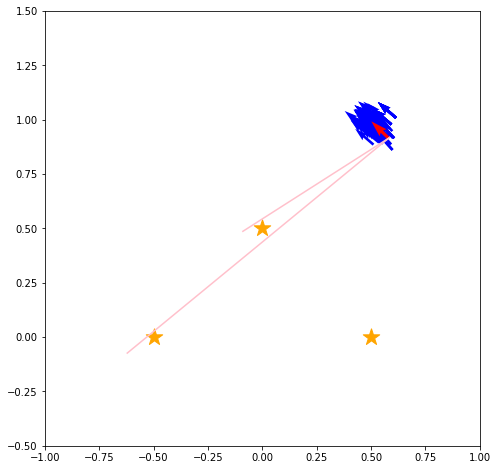

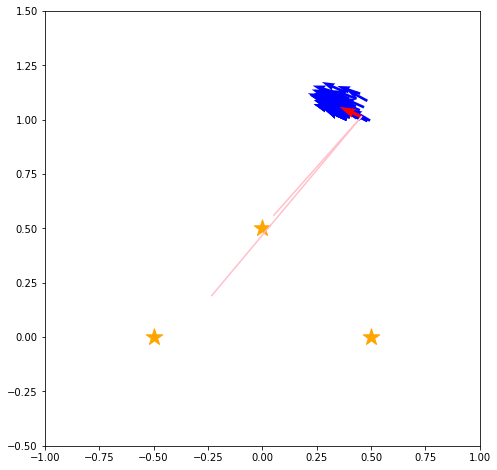

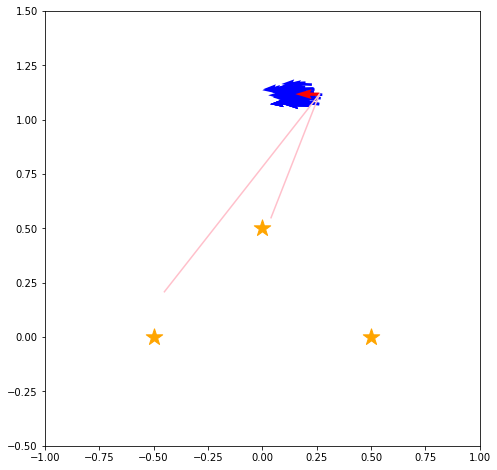

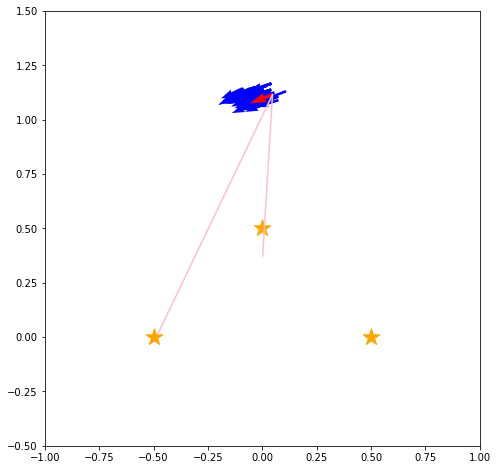

In [17]:
for i,p in enumerate(path):
    draw(path[i],particle_path[i])
    draw_landmarks(actual_landmarks)
    draw_observations(path[i],measurementss[i])